<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/modisco/Validate_crosscontinjacc_and_custom_density_adaptation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a notebook to investigate/validate the behavior of (1) the cross-continuous jaccard metric and (2) the custom density adaptation

Install modisco

In [1]:
!pip uninstall -y modisco
%cd /content/
!rm -rf tfmodisco
!git clone https://github.com/kundajelab/tfmodisco.git
%cd /content/tfmodisco
#!git checkout exposition
!git checkout exposition
!git log -1
!pip install .
%cd /content/

from importlib import reload
%load_ext autoreload
%autoreload 2

import modisco
reload(modisco)

/content
Cloning into 'tfmodisco'...
remote: Enumerating objects: 5910, done.
remote: Counting objects: 100% (536/536), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 5910 (delta 330), reused 521 (delta 323), pack-reused 5374
Receiving objects: 100% (5910/5910), 246.29 MiB | 24.23 MiB/s, done.
Resolving deltas: 100% (3677/3677), done.
/content/tfmodisco
Branch 'exposition' set up to track remote branch 'exposition' from 'origin'.
Switched to a new branch 'exposition'
commit 762a5cc787d7dda8d230460e7b17368fb9d59ff6 (HEAD -> exposition, origin/exposition)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Oct 6 16:48:13 2021 -0700

    name fix
Processing /content/tfmodisco
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.3 MB/s eta 0:00:00
  Created wheel for modisco: filename=modisco-0.5.15.0-py3-none-any.whl size=232381 sh

<module 'modisco' from '/usr/local/lib/python3.10/dist-packages/modisco/__init__.py'>

Install simdna to simulate sequences

In [2]:
!pip uninstall -y simdna
%cd /content/
!rm -rf simdna
!git clone https://github.com/kundajelab/simdna.git
%cd /content/simdna
!git checkout dev
!git log -1
!pip install .
%cd /content/

from importlib import reload
%load_ext autoreload
%autoreload 2

/content
Cloning into 'simdna'...
remote: Enumerating objects: 1237, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1237 (delta 57), reused 49 (delta 49), pack-reused 1172
Receiving objects: 100% (1237/1237), 3.94 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (744/744), done.
/content/simdna
Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'
commit e8488eba5eae123bc798bcbbdbc580497352608b (HEAD -> dev, origin/dev)
Author: Av Shrikumar <avanti.shrikumar@gmail.com>
Date:   Wed Sep 29 17:20:03 2021 -0700

    super fix
Processing /content/simdna
  Preparing metadata (setup.py) ... done
  Created wheel for simdna: filename=simdna-0.5.0.0-py3-none-any.whl size=643791 sha256=81455775047e9db2f045267d9eadbc0e773487989cfad5c68ea86238d5d80003
  Stored in directory: /tmp/pip-ephem-wheel-cache-3v3at_3c/wheels/72/26/9f/77d81351d437d7eb1326e830fa3d3a0ac57229e8190c528fdf
Successfully buil

Simulate two versions of two motifs

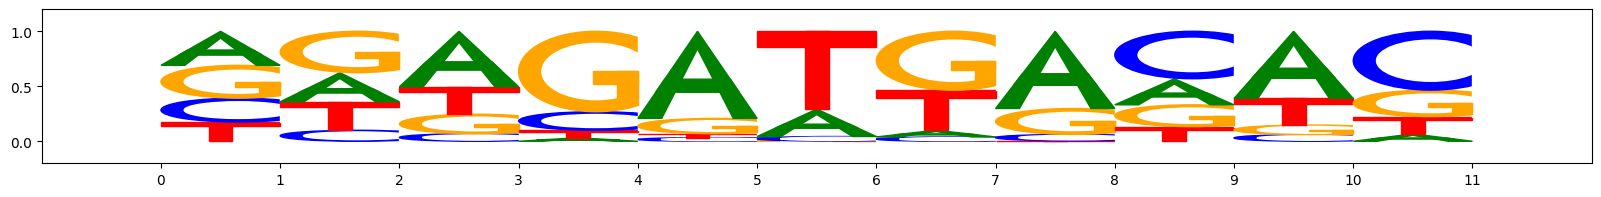

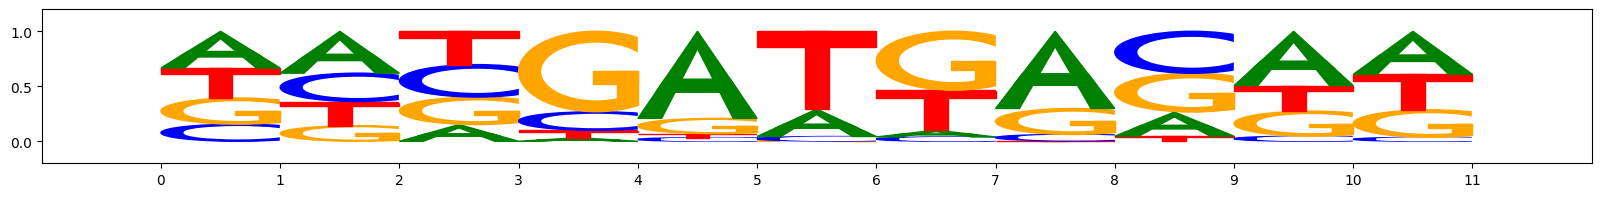

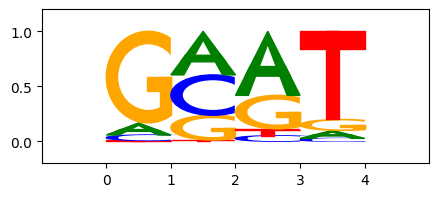

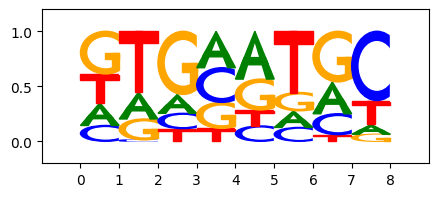

In [3]:
#motifs of varying lengths
#and of varying frequencies

import numpy as np
import modisco
from modisco.visualization import viz_sequence

rng = np.random.RandomState(1234)

def generate_ppm(rng, length, alpha):
    return rng.dirichlet(alpha*np.ones(4), size=length)

def gen_motif_with_diff_flanks(rng, core_len, core_alpha,
                                    flank_len, flank_alpha):
  motifcore = generate_ppm(rng, length=core_len, alpha=0.5)
  motifa = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                motifcore,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  motifb = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                motifcore,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  return motifa, motifb

def gen_motif_with_lower_ic_and_diff_flanks(rng, core_len, core_alpha, flank_len,
                                            flank_alpha, core_pc):
  motif_core = generate_ppm(rng, length=core_len, alpha=core_alpha)
  degraded_core = (motif_core +
                   np.array([core_pc, core_pc,
                             core_pc, core_pc])[None,:])/(1.0 + core_pc*4)
  motifa = np.concatenate([
              generate_ppm(rng, length=flank_len, alpha=flank_alpha),
                degraded_core,
              generate_ppm(rng, length=flank_len, alpha=flank_alpha)])
  return motif_core, motifa

motif1a, motif1b = gen_motif_with_diff_flanks(
                      rng=rng, core_len=5,
                      core_alpha=0.5, flank_len=3, flank_alpha=2.0)
viz_sequence.plot_weights(motif1a)
viz_sequence.plot_weights(motif1b)


motif2a, motif2b = gen_motif_with_lower_ic_and_diff_flanks(
                      rng=rng, core_len=4,
                      core_alpha=0.4, flank_len=2, flank_alpha=1.0,
                      core_pc=0.2) #core_pc is 'core_pseudocount'

viz_sequence.plot_weights(motif2a, figsize=(5,2))
viz_sequence.plot_weights(motif2b, figsize=(5,2))

motifs = [motif1a, motif1b, motif2a, motif2b]

Generate random sequences; these will be scanned for instances of the PWMs and scored accordingly

In [7]:
#generate simulate sequences
from importlib import reload
import simdna
reload(simdna.synthetic.substringgen)
from simdna.simdnautil.pwm import PWM
import simdna.synthetic as sn
import simdna

import numpy as np
np.random.seed(1234)
from simdna import random
random.seed(1234)

randseq_simulator = sn.EmbedInABackground(
    backgroundGenerator=sn.ZeroOrderBackgroundGenerator(
        seqLength=100,
        discreteDistribution={'A':0.27, 'C':0.23, 'G':0.23, 'T': 0.27}),
        embedders=[])

sn.print_sequences(
    outputFileName="randseq_sim.simdna",
    sequenceSetGenerator=sn.GenerateSequenceNTimes(randseq_simulator, N=1000),
    includeEmbeddings=True)

In [8]:
randseq_data = sn.read_simdata_file("randseq_sim.simdna")

In [9]:
#one-hot encode the seqs
import numpy as np
lookup = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1]}
def onehotencode_seqs(seqs):
  to_return = []
  for seq in seqs:
    to_return.append([lookup[letter] for letter in seq])
  return np.array(to_return)

randseq_onehot_seqs = onehotencode_seqs(randseq_data.sequences)

Compute the log-odds of each PWM for scoring the random sequences

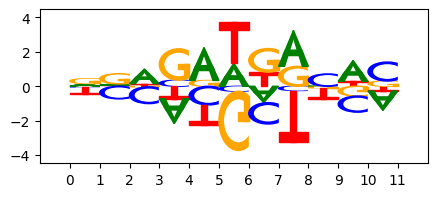

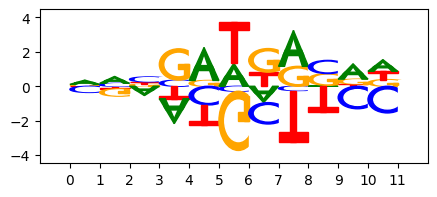

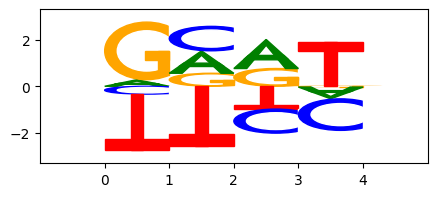

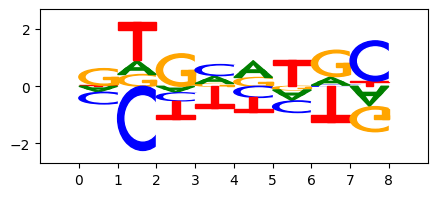

In [10]:
#score each sequence with the log-odds matrix of each pfm
background = np.array([0.27, 0.23, 0.23, 0.27])
pwms = [np.log(motif/background) for motif in motifs]
for pwm in pwms:
  viz_sequence.plot_weights(pwm - np.mean(pwm, axis=-1)[:,None], figsize=(5,2))

Scan each sequence with the PWMs. Greedily decide which PWM is binding at any given position.

In [11]:
import modisco
import numpy as np
import scipy
from collections import namedtuple


PwmHit = namedtuple("PwmHit", ["seq_idx", "pwm_start", "pwm_end", "which_pwm",
                                         "logodds_score"])


def get_pwm_hits_for_seq(seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds,
                         pwm_offsets, pwm_lengths, competition_window,
                         seq_idx):
    #Greedily decide which motifs get to bind
    #Pwm offsets should be the left padding that was applied to the logodds
    # scores for that particular pwm (depends on the pwm length)
    #seq_idx is provided just to insert that information into the hit
    maxlogodds_copy = np.copy(seq_pwm_axis_maxlogodds)
    sorted_positions = np.argsort(-maxlogodds_copy)

    pwm_hits = []
    for pos in sorted_positions:
        logodds_score = maxlogodds_copy[pos]
        if (logodds_score <= 0): #avoid 'less likely than bg' hits for this sim
            continue
        which_pwm = seq_pwm_axis_argmax[pos]
        #we want pwm_hits to represent the pwm start, hence the subtraction
        # of pwm_offsets
        pwm_start = pos-pwm_offsets[which_pwm]
        pwm_hits.append(PwmHit(seq_idx=seq_idx,
                               pwm_start=pwm_start,
                               pwm_end=pwm_start+pwm_lengths[which_pwm],
                               which_pwm=which_pwm,
                               logodds_score=logodds_score))
        clearance_start = pos - int(competition_window/2.0)
        clearance_end = clearance_start + competition_window
        maxlogodds_copy[clearance_start:clearance_end] = 0
    return pwm_hits


def scan_sequences(onehot_seqs, pwms):
  logodds_scans = []
  for pwm in pwms:
    logodds_scans.append(modisco.util.compute_pwm_scan(onehot_seq=onehot_seqs,
                                                       weightmat=pwm))
  return logodds_scans


def get_competitive_pwm_hits(onehot_seqs, pwms, competition_window):
    #Scan the sequences for logodds. Then:
    # (1) simulate competitive binding, in that only one motif is allowed to bind
    # in a window of length "competition_window" (centered at the motif)
    # (2) Decide which motif gets to bind greedily.

    logodds_scans = scan_sequences(onehot_seqs=onehot_seqs, pwms=pwms)
    pwm_lengths = [len(x) for x in pwms]

    #When a sequences is scanned,
    # the length of the result is orig_len-(windowlen-1). So we distribute
    # (windowlen-1) padding evenly on either side to make up for it.
    padded_logodds_scans = []
    pwm_offsets = [] #record the left-padding applied
    for (logodds_scan, pwm_len) in zip(logodds_scans, pwm_lengths):
      pwm_offset = int((pwm_len-1)/2.0)
      pwm_offsets.append(pwm_offset)
      padded_logodds_scans.append(
          np.pad(np.array(logodds_scan), (
            (0,0), (pwm_offset, (pwm_len-1)-pwm_offset )))
      )
    #assert that after padding they are all the same length. This will also make
    # the scores represent the score at the center of the pwm hit rather than
    # at the start.
    assert len(set(x.shape[1] for x in padded_logodds_scans)) == 1
    #make them all one numpy array so we can take an argmax over the pwm axis
    padded_logodds_scans = np.array(padded_logodds_scans)
    pwm_axis_argmax = np.argmax(padded_logodds_scans, axis=0)
    pwm_axis_maxlogodds = np.max(padded_logodds_scans, axis=0)
    allseq_pwm_hits = [
      get_pwm_hits_for_seq(seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds,
                           pwm_offsets=pwm_offsets, pwm_lengths=pwm_lengths,
                           competition_window=competition_window,
                           seq_idx=seq_idx)
      for (seq_idx, (seq_pwm_axis_argmax, seq_pwm_axis_maxlogodds)) in
      enumerate(zip(pwm_axis_argmax, pwm_axis_maxlogodds))
    ]

    #reorganize to be pwm-to-hits
    pwm_to_hits = [[] for pwm in pwms]
    for seq_idx, pwm_hits_for_seq in enumerate(allseq_pwm_hits):
      for pwm_hit in pwm_hits_for_seq:
        pwm_to_hits[pwm_hit.which_pwm].append(pwm_hit)

    return allseq_pwm_hits, pwm_to_hits


COMPETITION_WINDOW = max([len(x) for x in pwms])

(randseq_allseq_pwm_hits, randseq_pwm_to_hits) = get_competitive_pwm_hits(
    onehot_seqs=randseq_onehot_seqs, pwms=pwms,
    competition_window=COMPETITION_WINDOW)

Assign scores to each base according to which PWM is binding most strongly to the region surrounding the base

In [53]:

def logodds_to_score(logodds):
  MU = -4
  EXPFACTOR = 3
  #return logodds
  #return scipy.special.expit(logodds+MU)
  return np.exp(EXPFACTOR*scipy.special.expit(logodds+MU))

def find_imp(onehot_seqs, allseq_pwm_hits, pwms, noisefold):
    ref = logodds_to_score(0)
    simulated_hyp_scores = np.zeros_like(onehot_seqs, dtype="float64")
    for row_idx in range(len(allseq_pwm_hits)):
      for pwm_hit in allseq_pwm_hits[row_idx]:
        assert pwm_hit.seq_idx==row_idx
        score = logodds_to_score(pwm_hit.logodds_score)
        diff_from_ref = score-ref
        assert np.sign(diff_from_ref)==np.sign(pwm_hit.logodds_score)
        scalefactor = diff_from_ref/pwm_hit.logodds_score
        simulated_hyp_scores[row_idx][
            pwm_hit.pwm_start:pwm_hit.pwm_end]\
                += pwms[pwm_hit.which_pwm]*scalefactor
    #Add noise, adjusting values to be up to 2^noisefold more/less (multiplicatively)
    # from that they are up to. Sample uniformly.
    noisefold_adjustment = np.power(2, np.random.RandomState(1234).uniform(
        low=-noisefold, high=noisefold, size=simulated_hyp_scores.shape))
    simulated_actual_scores = simulated_hyp_scores*noisefold_adjustment*onehot_seqs
    return simulated_hyp_scores, simulated_actual_scores

#imulate no noise for this case; results are similar with noisefold=1
randseq_hyp_scores, randseq_actual_scores = find_imp(onehot_seqs=randseq_onehot_seqs,
                                           allseq_pwm_hits=randseq_allseq_pwm_hits,
                                           pwms=pwms, noisefold=0)

sequence 0


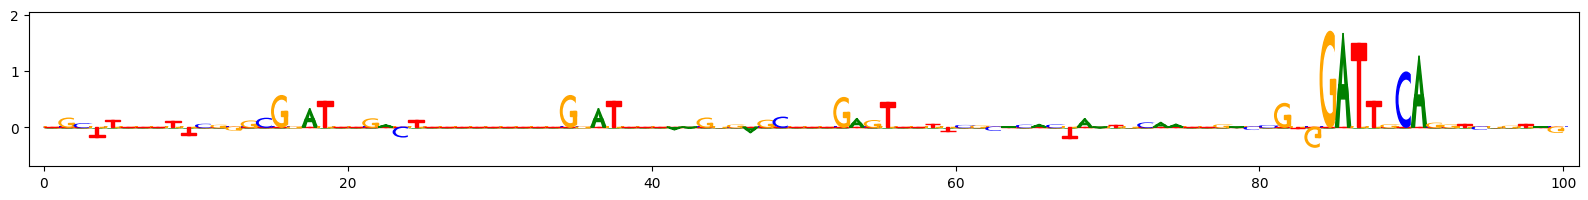

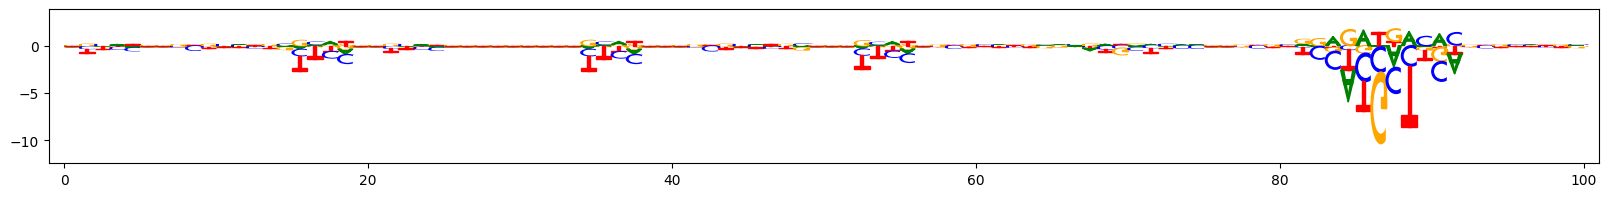

sequence 1


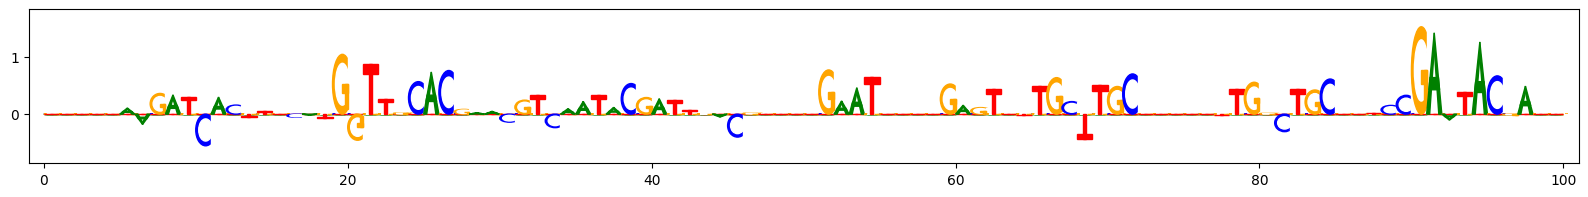

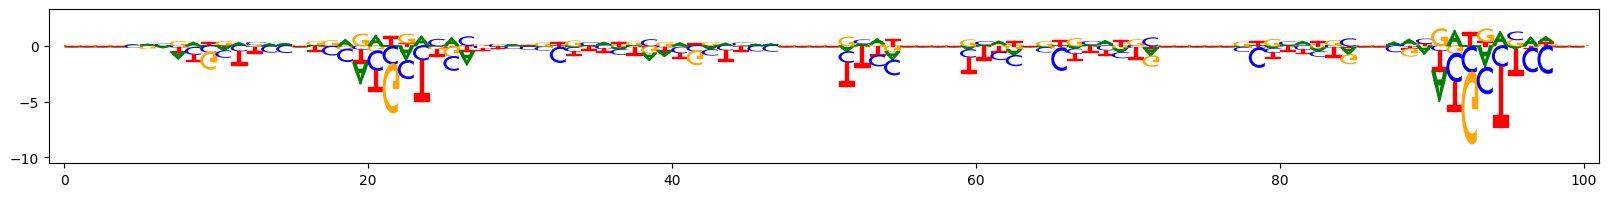

In [54]:
from modisco.visualization import viz_sequence

for i in range(2):
  print("sequence",i)
  viz_sequence.plot_weights(randseq_actual_scores[i], subticks_frequency=20)
  viz_sequence.plot_weights(randseq_hyp_scores[i], subticks_frequency=20)

Extract seqlets for all pwm hits where the logodds score is > 2

In [55]:
from modisco.core import SeqletCoordinates

#identify (centered) seqlet coordinates for each motif
seqlet_len = 15
pwm_seqlet_coords = [ [] for pwm in pwms]

for pwm_hits in randseq_pwm_to_hits:
    for pwm_hit in pwm_hits:
        if (pwm_hit.logodds_score > 2):
          pwm_len = pwm_hit.pwm_end - pwm_hit.pwm_start
          left_flank = int((seqlet_len - pwm_len)/2.0)
          seqlet_start = pwm_hit.pwm_start - left_flank
          seqlet_end = seqlet_start + seqlet_len
          if (seqlet_start >= 0) and (seqlet_end <= randseq_onehot_seqs.shape[1]):
            pwm_seqlet_coords[pwm_hit.which_pwm].append(
                SeqletCoordinates(example_idx=pwm_hit.seq_idx,
                                  start=seqlet_start, end=seqlet_end,
                                  is_revcomp=False))

#get the seqlets from the trackset object
track_set = modisco.tfmodisco_workflow.workflow.prep_track_set(
              task_names=["task0"], contrib_scores={"task0": randseq_actual_scores},
              hypothetical_contribs={"task0": randseq_hyp_scores},
              one_hot=randseq_onehot_seqs, revcomp=False)
pwm_seqlets = [track_set.create_seqlets(coords=coords)
               for coords in pwm_seqlet_coords]



Subsample the seqlets to make the clustering problem harder

In [81]:
print("orig number of pwm seqlets", [len(x) for x in pwm_seqlets])
num_per_pwm = np.array([30, 30, 200, 200]) #numbers to subsample to
assert len(num_per_pwm)==len(pwm_seqlets)

def subsample_list(the_list, num_to_sample):
    subsample_idxs = np.random.RandomState(1234).choice(
      a=np.arange(len(the_list)), replace=False,
      size=min(num_to_sample,len(the_list)) )
    subsamp_items = [the_list[i] for i in subsample_idxs]
    return subsamp_items

sub_seqlets = [x for (the_pwm_seqlets, num_to_sample)
                     in zip(pwm_seqlets, num_per_pwm)
                     for x in subsample_list(the_pwm_seqlets, num_to_sample) ]
sub_seqlets_whichpwms = np.array([pwm_idx for pwm_idx in range(len(num_per_pwm))
                                  for x in range(num_per_pwm[pwm_idx])])

from collections import Counter
print(Counter(sub_seqlets_whichpwms))


orig number of pwm seqlets [830, 935, 1378, 1107]
Counter({2: 200, 3: 200, 0: 30, 1: 30})


Now compare the crosscorr metric to the v cross continuous jaccard metric according to how well they can distinguish neighbors that are from the same motif type vs. from a different motif type

In [82]:

# compute the pairwise sims using continjacc
def compute_pairwise_sims_continjacc(seqlets):
    pattern_comparison_settings =(
        modisco.affinitymat.core.PatternComparisonSettings(
                    track_names=["task0_hypothetical_contribs",
                                "task0_contrib_scores"],
                    track_transformer=modisco.affinitymat.L1Normalizer(),
                    min_overlap=0.7))
    affmat_from_seqlets_with_nn_pairs =(
        modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(
            pattern_comparison_settings=pattern_comparison_settings,
            sim_metric_on_nn_pairs=(
                modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                    n_cores=10,
                    cross_metric_single_region=
                        modisco.affinitymat.core.CrossContinJaccardSingleRegion()))))
    return affmat_from_seqlets_with_nn_pairs(seqlets=seqlets)


all_pairwise_sims = compute_pairwise_sims_continjacc(sub_seqlets)

nearest_neighbors = np.argsort(-all_pairwise_sims, axis=-1)
nn_pairwise_sims = np.maximum(np.array([
    row[nn] for row,nn in zip(all_pairwise_sims, nearest_neighbors) ]), 0.0)


Launching nearest neighbors affmat calculation job
MEMORY 0.509095936
Parallel runs completed
MEMORY 0.50917376
Job completed in: 2.88 s
MEMORY 0.509087744


In [83]:
#compute pairwise similarities using cross corr
def compute_pairwise_sims_crosscorr(seqlets):
#    print("Num seqlets:", len(seqlets))
    #get the emebedding
    pattern_comparison_settings =(
        modisco.affinitymat.core.PatternComparisonSettings(
                    track_names=["task0_hypothetical_contribs",
                                 "task0_contrib_scores"],
                    #similar results with just the magnitude norm
                    #track_transformer=modisco.affinitymat.MagnitudeNormalizer(),
                    track_transformer=modisco.affinitymat.MeanNormalizer().chain(
                                       modisco.affinitymat.MagnitudeNormalizer()),
                    min_overlap=0.7))
    affmat_from_seqlets_with_nn_pairs =(
        modisco.affinitymat.core.AffmatFromSeqletsWithNNpairs(
            pattern_comparison_settings=pattern_comparison_settings,
            sim_metric_on_nn_pairs=(
                modisco.affinitymat.core.ParallelCpuCrossMetricOnNNpairs(
                    n_cores=10,
                    cross_metric_single_region=
                        modisco.affinitymat.core.CrossCorrSingleRegion()))))
    return affmat_from_seqlets_with_nn_pairs(seqlets=seqlets)

all_pairwise_sims_crosscorr = compute_pairwise_sims_crosscorr(sub_seqlets)
nearest_neighbors_crosscorr = np.argsort(-all_pairwise_sims_crosscorr, axis=-1)
nn_pairwise_sims_crosscorr = np.array([
    row[nn] for row,nn in zip(all_pairwise_sims_crosscorr, nearest_neighbors_crosscorr) ])

Launching nearest neighbors affmat calculation job
MEMORY 0.509087744
Parallel runs completed
MEMORY 0.509100032
Job completed in: 1.26 s
MEMORY 0.509100032


Pwm 0  - crosscontin
Within vs between auroc 0.9637504737295434


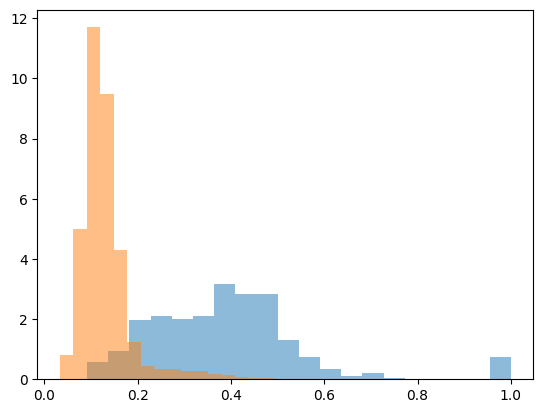

Pwm 0 - crosscorr
Within vs between auroc 0.9210678725236865


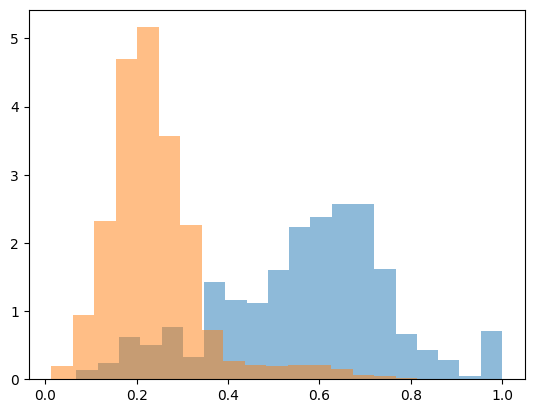

Pwm 1  - crosscontin
Within vs between auroc 0.9425509043927649


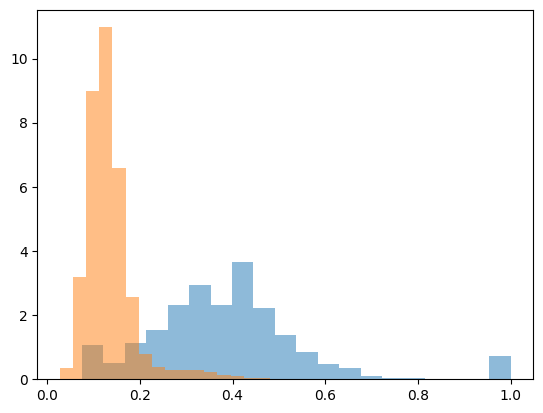

Pwm 1 - crosscorr
Within vs between auroc 0.9298881998277347


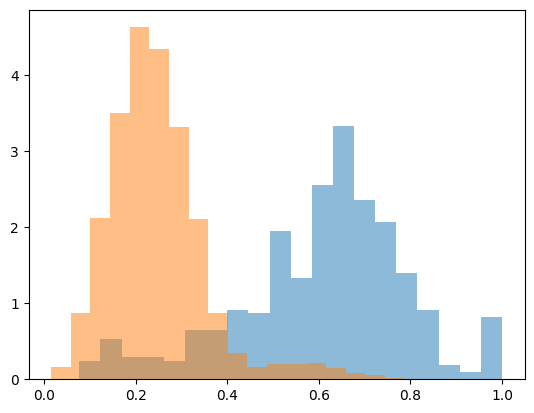

Pwm 2  - crosscontin
Within vs between auroc 0.9570030528846154


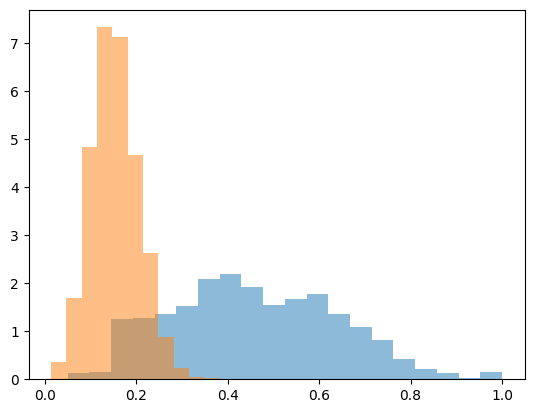

Pwm 2 - crosscorr
Within vs between auroc 0.9534483370192308


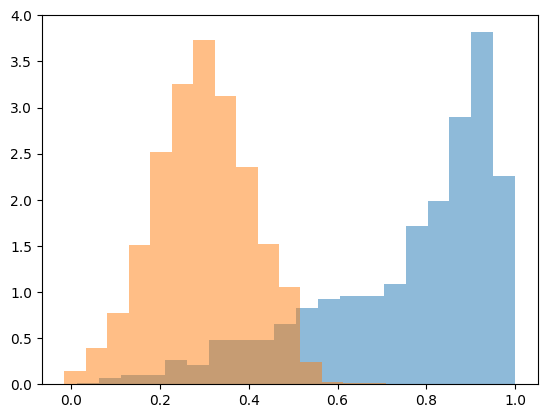

Pwm 3  - crosscontin
Within vs between auroc 0.8463527596153847


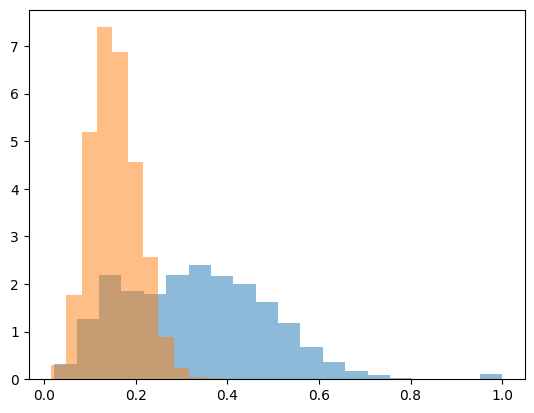

Pwm 3 - crosscorr
Within vs between auroc 0.8063166538461539


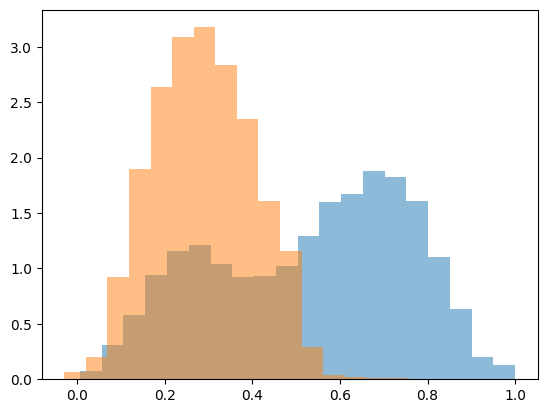

In [84]:
from matplotlib import pyplot as plt
import sklearn.metrics

#histogram within-cluster vs. between-cluster similarities for different classes
for i in range(len(pwms)):
  print("Pwm",i," - crosscontin")
  within_crosscontin = (all_pairwise_sims[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms==i]).ravel()
  between_crosscontin = (all_pairwise_sims[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms!=i]).ravel()
  print("Within vs between auroc", sklearn.metrics.roc_auc_score(y_true=[1 for x in within_crosscontin]+[0 for x in between_crosscontin], y_score=list(within_crosscontin)+list(between_crosscontin)) )
  plt.hist(within_crosscontin, bins=20, alpha=0.5, density=True)
  plt.hist(between_crosscontin, bins=20, alpha=0.5, density=True)
  plt.show()
  print("Pwm",i,"- crosscorr")
  within_crosscorr = (all_pairwise_sims_crosscorr[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms==i]).ravel()
  between_crosscorr = (all_pairwise_sims_crosscorr[sub_seqlets_whichpwms==i,:][:,sub_seqlets_whichpwms!=i]).ravel()
  print("Within vs between auroc", sklearn.metrics.roc_auc_score(y_true=[1 for x in within_crosscorr]+[0 for x in between_crosscorr], y_score=list(within_crosscorr)+list(between_crosscorr)) )
  plt.hist(within_crosscorr, bins=20, alpha=0.5, density=True)
  plt.hist(between_crosscorr, bins=20, alpha=0.5, density=True)
  plt.show()

Also investigate density adaptation

First do the stanard scikit density adaptation with different perplexities

In [93]:

def get_density_adapted_affmat(affmat_nn, nn, perplexity):
    densadapter =\
      modisco.affinitymat.transformers.NNTsneConditionalProbs(
                  perplexity=perplexity,
                  aff_to_dist_mat=
                   modisco.affinitymat.transformers.AffToDistViaInvLogistic())
    coo_density_adapted_affmat = densadapter(affmat_nn, nn)
    return coo_density_adapted_affmat

perplexities_list = [10, 20, 40, 80, 160, 320];

densadapted_sims_perplexitylist = [get_density_adapted_affmat(affmat_nn=nn_pairwise_sims,
                                              nn=nearest_neighbors,
                                              perplexity=perplexity)
                                   for perplexity in perplexities_list]

[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.274140
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.325051
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.374811
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.449973
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.583395
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.833537


Also compute the custom density adaptation

In [87]:
PERPLEXITY = 10

def do_density_adaptation_custom(new_rows_distmat_nn, new_rows_nn,
                              new_rows_betas, new_rows_normfactors):
    new_rows_densadapted_affmat_nn = []
    for i in range(len(new_rows_distmat_nn)):
        densadapted_row = []
        for j,distance in zip(new_rows_nn[i], new_rows_distmat_nn[i]):
            densadapted_row.append(np.sqrt(
              (np.exp(-distance/new_rows_betas[i])/new_rows_normfactors[i])
              *(np.exp(-distance/new_rows_betas[j])/
                new_rows_normfactors[j])))
        new_rows_densadapted_affmat_nn.append(densadapted_row)
    return new_rows_densadapted_affmat_nn


def get_density_embeddings_custom(affmat_nn, seqlet_neighbors):
    distmat_nn = modisco.affinitymat.AffToDistViaInvLogistic()(affmat_nn)
    sym_seqlet_neighbors, sym_distmat_nn = modisco.util.symmetrize_nn_distmat(
                  distmat_nn=distmat_nn, nn=seqlet_neighbors,
                  average_with_transpose=True)

    #Compute beta values for the density adaptation. *store it*
    betas_and_ps = [modisco.util.binary_search_perplexity(PERPLEXITY, distances)
                    for distances in sym_distmat_nn]
    betas = np.array([x[0] for x in betas_and_ps])

    #compute norm factors
    densadapted_affmat_nn_unnorm = [np.exp(-np.array(distmat_row)/beta)
        for distmat_row, beta in zip(sym_distmat_nn, betas)]
    normfactors = np.array([max(np.sum(x),1e-8) for x in
                            densadapted_affmat_nn_unnorm])
    #do the density adaptation
    sym_densadapted_affmat_nn = do_density_adaptation_custom(
        new_rows_distmat_nn=sym_distmat_nn,
        new_rows_nn=sym_seqlet_neighbors,
        new_rows_betas=betas,
        new_rows_normfactors=normfactors)
    modisco.util.verify_symmetric_nn_affmat(
        affmat_nn=sym_densadapted_affmat_nn,
        nn=sym_seqlet_neighbors)
    csr_density_adapted_affmat =\
                modisco.util.coo_matrix_from_neighborsformat(
                    entries=sym_densadapted_affmat_nn,
                    neighbors=sym_seqlet_neighbors,
                    ncols=len(sym_densadapted_affmat_nn)).tocsr()

    return csr_density_adapted_affmat

manual_densadapted_sims_custom = get_density_embeddings_custom(nn_pairwise_sims, nearest_neighbors);

Compute Leiden clusters using no density adaptation

In [88]:
clusterer1 = modisco.cluster.core.LeidenClusterParallel(
                n_jobs=10,
                affmat_transformer=
                    modisco.affinitymat.transformers.SymmetrizeByAddition(
                                                   probability_normalize=True),
                numseedstotry=50,
                n_leiden_iterations=-1,
                verbose=True)

nodensadapted_leidenclusters = clusterer1(
    modisco.util.coo_matrix_from_neighborsformat(
                    entries=nn_pairwise_sims,
                    neighbors=nearest_neighbors,
                    ncols=len(nn_pairwise_sims)).tocsr(),
    initclusters=None)


Beginning preprocessing + Leiden
Affmat shape: 460


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.1min


Quality: 0.20229042885724688


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.5min finished


Compute the clustering with the standard scikit density adaptation with different perplexities

In [94]:
densadapted_leidenclusters_perplexitylist = [
    clusterer1(densadapted_sims, initclusters=None)
    for densadapted_sims in densadapted_sims_perplexitylist]

Beginning preprocessing + Leiden
Affmat shape: 460


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   37.1s


Quality: 0.7402041166036507
Quality: 0.7402742678277834
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   52.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   39.1s


Quality: 0.6888643017485916
Quality: 0.68891384455008
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   55.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   42.5s


Quality: 0.6346822791811405
Quality: 0.63502207723374
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   58.0s


Quality: 0.5653507401133241
Quality: 0.565470260832722
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.2min


Quality: 0.49490878584952364
Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.0min


Quality: 0.3053017171981203


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.5min finished


Compute the clustering with the custom density adaptation

In [90]:
clusterer2 = modisco.cluster.core.LeidenClusterParallel(
      n_jobs=10,
      affmat_transformer=
        modisco.affinitymat.transformers.AdhocAffMatTransformer(lambda x: x),
      numseedstotry=50,
      n_leiden_iterations=-1,
      verbose=True)

densadapted_leidenclusters_custom = clusterer2(manual_densadapted_sims_custom,
    initclusters=None)

Beginning preprocessing + Leiden


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Affmat shape: 460


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   58.0s


Quality: 0.04438071534909057


[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:  1.4min finished


For visualization, compute an embedding into 2 dimensions using T-SNE

In [91]:
from matplotlib import pyplot as plt
import sklearn.manifold

invlogistic_distmat = modisco.affinitymat.AffToDistViaInvLogistic()(
                        all_pairwise_sims)
invlogistic_embedding = sklearn.manifold.TSNE(
                perplexity=PERPLEXITY,
                init="random",
                metric='precomputed',
                verbose=3, random_state=1234).fit_transform(invlogistic_distmat)


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 460 samples in 0.002s...
[t-SNE] Computed neighbors for 460 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 460 / 460
[t-SNE] Mean sigma: 0.294087
[t-SNE] Computed conditional probabilities in 0.006s
[t-SNE] Iteration 50: error = 67.2436447, gradient norm = 0.1281612 (50 iterations in 0.164s)
[t-SNE] Iteration 100: error = 63.8743439, gradient norm = 0.0544594 (50 iterations in 0.107s)
[t-SNE] Iteration 150: error = 63.2059631, gradient norm = 0.0241863 (50 iterations in 0.105s)
[t-SNE] Iteration 200: error = 63.3146744, gradient norm = 0.0555772 (50 iterations in 0.094s)
[t-SNE] Iteration 250: error = 63.1413383, gradient norm = 0.0265113 (50 iterations in 0.111s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.141338
[t-SNE] Iteration 300: error = 1.0595658, gradient norm = 0.0142191 (50 iterations in 0.130s)
[t-SNE] Iteration 350: error = 0.9051449, gradient norm = 0.0097158 (

Now visualize the results; this is subjective, but in the 'ideal' results we descided to the two versions of the first motif together as their differences are very subtle, and separate the two versions of the second motif as they have more obvious differences

Ideal


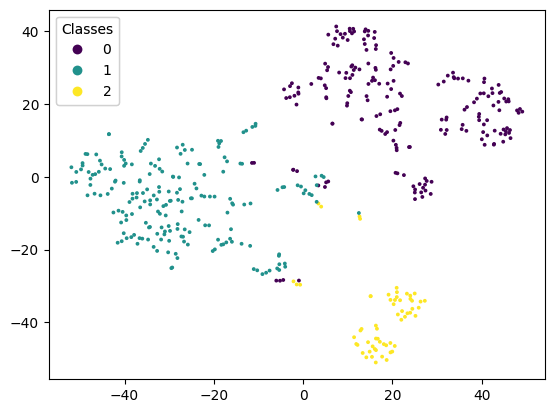

Unadapted Counter({0: 186, 1: 182, 2: 92})


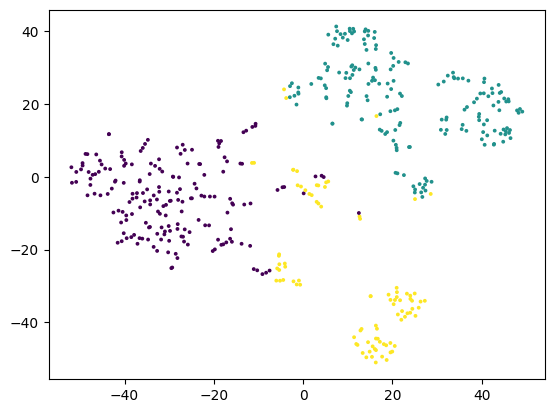

Custom adaptation Counter({0: 200, 1: 187, 2: 73})


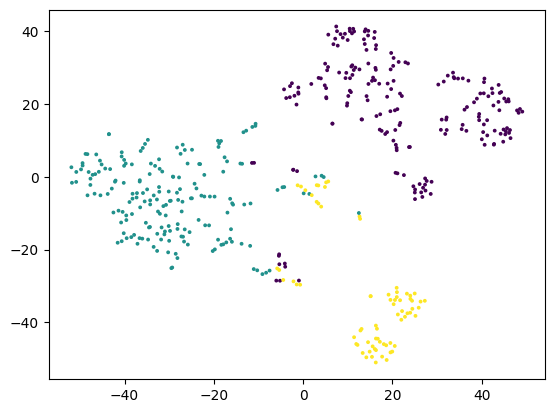

original scikit-based adaptation (different perplexities)
perplexity: 320 Counter({0: 193, 1: 177, 2: 78, 3: 12})


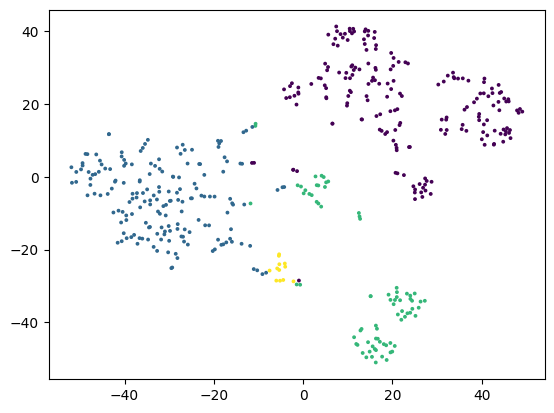

perplexity: 160 Counter({0: 183, 1: 173, 2: 57, 3: 28, 4: 19})


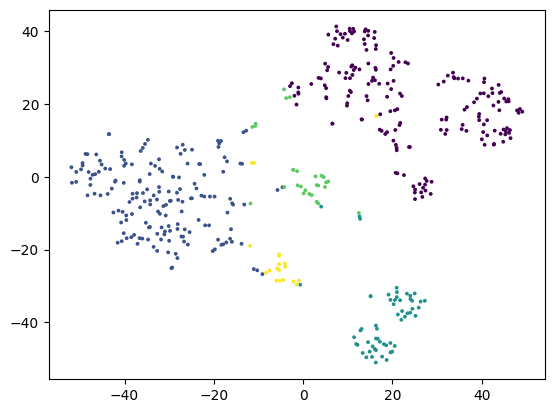

perplexity: 80 Counter({0: 167, 1: 152, 2: 65, 3: 55, 4: 21})


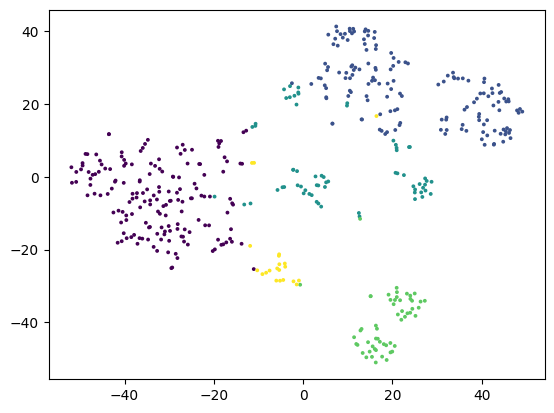

perplexity: 40 Counter({0: 154, 1: 89, 2: 65, 3: 53, 4: 42, 5: 32, 6: 25})


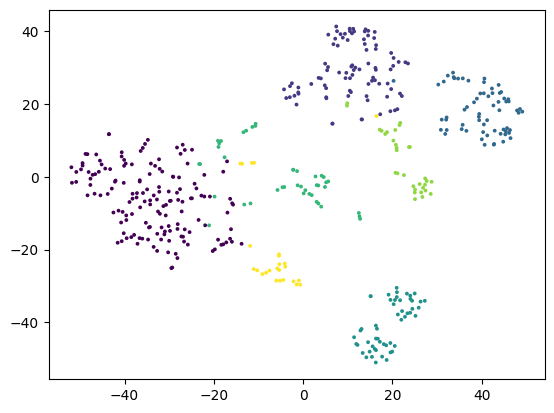

perplexity: 20 Counter({0: 145, 1: 80, 2: 64, 3: 53, 4: 48, 5: 35, 6: 19, 7: 16})


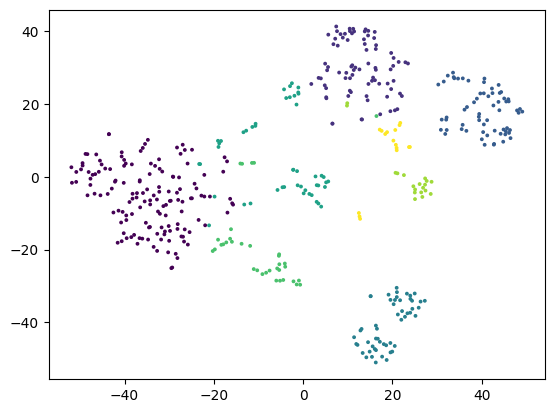

perplexity: 10 Counter({0: 97, 1: 72, 2: 62, 3: 55, 4: 53, 5: 34, 6: 25, 7: 22, 8: 21, 9: 19})


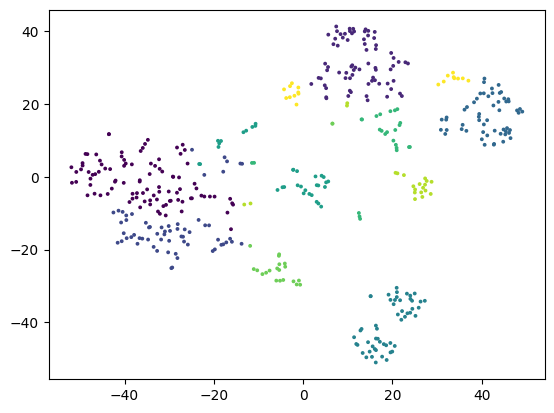

In [95]:
from collections import Counter

print("Ideal")
#(we are adjusting the coloring to match the coloring of other clusterings for ease of comparison)
scatter = plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=[2 if (i==1 or i==0) else (i-2) for i in sub_seqlets_whichpwms])
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.show()

print("Unadapted", Counter(nodensadapted_leidenclusters.cluster_indices))
plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=nodensadapted_leidenclusters.cluster_indices)
plt.show()

print("Custom adaptation", Counter(densadapted_leidenclusters_custom.cluster_indices))
plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
            c=densadapted_leidenclusters_custom.cluster_indices)
plt.show()

print("original scikit-based adaptation (different perplexities)")
for densadapted_leidenclusters, perplexity in zip(
    densadapted_leidenclusters_perplexitylist[::-1], perplexities_list[::-1]):
  print("perplexity:", perplexity, Counter(densadapted_leidenclusters.cluster_indices))
  plt.scatter(invlogistic_embedding[:,0], invlogistic_embedding[:,1], s=3,
              c=densadapted_leidenclusters.cluster_indices)
  plt.show()

